# Example notebook for operations with .gds files with pyMOE

In the following several operations in .gds files using the gds_klops module are exemplified, including:
* Change layers within a .gds file 
* Make an instance array from an existing .gds file 
* Import one .gds file into another .gds file
* Rescale all the .gds layout by a factor 
* Pass a .gds file into a .dxf file 

In [1]:
%matplotlib notebook
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}


import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../..')

from matplotlib import pyplot as plt 
import numpy as np 

from scipy.constants import micro, nano, milli

import pyMOE as moe 


## Preliminary: Generate a Fresnel Phase Mask 

<IPython.core.display.Javascript object>


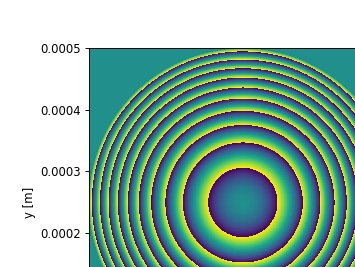

<IPython.core.display.Javascript object>


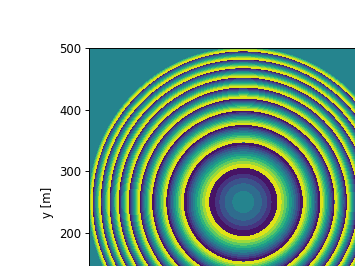

Creating contours 
[Create Contours]
Elapsed: 0:00:06.529581
Passing contours into GDS. 
0
1
2
3
4
5
6
7
8
9
[Total time converting to GDS]
Elapsed: 0:00:17.694482
Saved fresnel_phase_mask.gds


In [2]:
####generate a fresnel phase mask and save it into gds  

npix = 5000 # nr of pixels 
foc = 5000 # focal distance in um 
lda = 0.6328 #wavelength in um 
xsiz = 500 #x-size in um 
ysiz = 500 #y-size in um 
n = 10  # number of gray levels 
gdsname = "fresnel_phase_mask.gds" # name of gds file

#moe.generate.fresnel_phase_mask(npix, foc, lda, xsiz, ysiz, n, filename=gdsname, plotting=True)
# Create empty mask
aperture2 = moe.generate.create_empty_aperture(0, xsiz*micro, npix, 0, ysiz*micro, npix,)
# f=25mm, lambda=532nm, R=500µm

center = (xsiz*micro/2, ysiz*micro/2)

# and truncate around radius
mask2 = moe.generate.fresnel_phase(aperture2, foc * micro, lda * micro, radius=xsiz/2*micro, center = center)
moe.plotting.plot_aperture(mask2, )

mask2.discretize(n+1) 
moe.plotting.plot_aperture(mask2)

gdsmask = moe.GDSMask(mask2)

# Create layout and merge polygons together
gdsmask.create_layout(mode = "contour", merge=True) ## or mode ="raster"

gdsmask.write_gds(gdsname)



## Operations with/on .gds files

Using the generated fresnel phase mask .gds file, below it is demonstrated how to make some operations with the .gds using the gds_klops module 

In [3]:
#Exemplifying the change_layers function 
import numpy as np

fstgds_filename = "fresnel_phase_mask.gds"
fst_cellname = "TOP"
#layers in the original file (here is just from 0 to n)
layerspol = np.arange(0,n,dtype=int)
# the correspondence is one-to-one to layerspol 
gvts = layerspol+5 
output_filename = "fresnel_phase_mask_newlayers.gds"

moe.gdsops.change_layers(fstgds_filename, fst_cellname, layerspol, gvts, output_filename)


Changed the shapes in layer 0 into 5
Changed the shapes in layer 1 into 6
Changed the shapes in layer 2 into 7
Changed the shapes in layer 3 into 8
Changed the shapes in layer 4 into 9
Changed the shapes in layer 5 into 10
Changed the shapes in layer 6 into 11
Changed the shapes in layer 7 into 12
Changed the shapes in layer 8 into 13
Changed the shapes in layer 9 into 14
Changed layers - wrote result to fresnel_phase_mask_newlayers.gds


In [4]:
#Do an instance array

input_filename = "fresnel_phase_mask_newlayers.gds"
cell_name = "top" #name of the cell for instance array cannot be the same as the input gds filename
transx = 1000  #translation vector in X  in um
transy = 1000  #translation vector in Y  in um 
nr_inst_X = 3  #number of instances in X 
nr_inst_Y = 3  #number of instances in Y 
pitx = xsiz   #translation in X in um - use same dist as in the generated mask 
pity = ysiz   #translation in Y in um
output_filename = "fresnel_phase_mask_newlayers_"+str(nr_inst_X)+"x"+str(nr_inst_Y)+".gds"


moe.gdsops.instance_array(cell_name, input_filename, transx, transy, nr_inst_X, nr_inst_Y, pitx, pity, output_filename)


In [5]:
##import a .gds file into another .gds

fstgds_filename = "fresnel_phase_mask_newlayers_"+str(nr_inst_X)+"x"+str(nr_inst_Y)+".gds"
fst_cellname = cell_name 
sndgds_filename = "fresnel_phase_mask.gds"
snd_cellname = "TOP"
output_filename = "fresnel_phase_mask+fresnelarray.gds"

#Only need to loop through the layers 
for ids, layin in enumerate(layerspol): 
    if ids == 0 :
        moe.gdsops.import_gds(fstgds_filename, fst_cellname, int(layin), int(0), \
               sndgds_filename, snd_cellname,  int(layin), int(0), \
               output_filename, clear_gds = False)
    else: 
        moe.gdsops.import_gds(output_filename, fst_cellname, int(layin), int(0), \
               sndgds_filename, snd_cellname, int(layin), int(0), \
               output_filename, clear_gds = False)



Imported fresnel_phase_mask.gds layer 0 into fresnel_phase_mask_newlayers_3x3.gds layer 0. Output file fresnel_phase_mask+fresnelarray.gds .
Imported fresnel_phase_mask.gds layer 1 into fresnel_phase_mask+fresnelarray.gds layer 1. Output file fresnel_phase_mask+fresnelarray.gds .
Imported fresnel_phase_mask.gds layer 2 into fresnel_phase_mask+fresnelarray.gds layer 2. Output file fresnel_phase_mask+fresnelarray.gds .
Imported fresnel_phase_mask.gds layer 3 into fresnel_phase_mask+fresnelarray.gds layer 3. Output file fresnel_phase_mask+fresnelarray.gds .
Imported fresnel_phase_mask.gds layer 4 into fresnel_phase_mask+fresnelarray.gds layer 4. Output file fresnel_phase_mask+fresnelarray.gds .
Imported fresnel_phase_mask.gds layer 5 into fresnel_phase_mask+fresnelarray.gds layer 5. Output file fresnel_phase_mask+fresnelarray.gds .
Imported fresnel_phase_mask.gds layer 6 into fresnel_phase_mask+fresnelarray.gds layer 6. Output file fresnel_phase_mask+fresnelarray.gds .
Imported fresnel_ph

In [6]:
# rescaling the layout 
readfile = "fresnel_phase_mask.gds"
cellname = "TOP"
factor = 2 #Factor to rescale the layout to 
outfile = "fresnel_phase_mask_rescale.gds"


moe.gdsops.rescale_layout(readfile, cellname, factor, outfile, divfactor=1)

Rescaled fresnel_phase_mask.gdsby a factor of 2.0
Saved the result to fresnel_phase_mask_rescale.gds


In [7]:
#export .gds to .dxf
ingds = "fresnel_phase_mask_rescale.gds"
outdxf = "fresnel_phase_mask_rescale.dxf"


moe.gdsops.gds_to_dxf(ingds, outdxf)

In [8]:
##Merging all layers within a multi-layer file 
inputfile = "fresnel_phase_mask_rescale.gds"
outputfile = "fresnel_phase_mask_rescale+merged.gds"
cellname = "TOP" #name of the gds cell 
datatype = int(0)

for ids, layin in enumerate(layerspol): 
    print(layin)
    if ids == 0 :
        moe.gdsops.merge_layer(inputfile,cellname, int(layin), datatype ,outputfile )
    else: 
        moe.gdsops.merge_layer(outputfile,cellname, int(layin), datatype ,outputfile )
        

0
Merged layers in fresnel_phase_mask_rescale+merged.gds
1
Merged layers in fresnel_phase_mask_rescale+merged.gds
2
Merged layers in fresnel_phase_mask_rescale+merged.gds
3
Merged layers in fresnel_phase_mask_rescale+merged.gds
4
Merged layers in fresnel_phase_mask_rescale+merged.gds
5
Merged layers in fresnel_phase_mask_rescale+merged.gds
6
Merged layers in fresnel_phase_mask_rescale+merged.gds
7
Merged layers in fresnel_phase_mask_rescale+merged.gds
8
Merged layers in fresnel_phase_mask_rescale+merged.gds
9
Merged layers in fresnel_phase_mask_rescale+merged.gds


In [9]:
###Make STL into